## 引入工具

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
# %watermark -p numpy,sklearn,pandas
# %watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
# %watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x):
    try: 
        x = x.strip()
        if x[0] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                uri = 'https://' + x
                x = requests.get(uri)
                if x.status_code == 200:
                    x = x.text
            elif x.startswith('github.com'):
                uri = x.replace('github.com', 'raw.githubusercontent.com')
                mod = uri.split('/')
                for s in ['main', 'master']:
                    uri = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[-3:])
                    x = requests.get(uri)
                    if x.status_code == 200:
                        x = x.text
                        break
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                for s in ['/raw/main/', '/raw/master/']:
                    uri = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[3:])
                    x = requests.get(uri)
                    if x.status_code == 200:
                        x = x.text
                        break
        exec(x, globals())
    except:
        pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)


## 解析配置

In [2]:
_IMPORT('/data/nb_easy/easy_widget.py')

In [3]:
from utils import EVENTS

RACEURL = 'http://116.85.68.193:9119'
MSGKEY = 'nb.zmq.repnet_tf.gamma103'

with open('schema.json', 'r') as fr:
    schema_string = fr.read()
    schema_string = schema_string.replace('zmq.repnet_tf.test', MSGKEY)
    schema_string = schema_string.replace('http://host:port', RACEURL)
    schema = json.loads(schema_string)
easy = nbeasy_schema_parse(schema, events=EVENTS, debug=True);

Box(children=(Box(children=(VBox(children=(Tab(children=(VBox(children=(HBox(children=(Text(value='zmq.repnet_…

In [4]:
raise

RuntimeError: No active exception to reraise

1. https://frepai.s3.didiyunapi.com/datasets/vod/木槌加固/20211206123823.mp4

## Tools

In [197]:
import numpy as np
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd
from sklearn import preprocessing
from matplotlib.colors import LogNorm

In [6]:
def _denormal_image(x):
    x -= x.mean()
    x /= x.std()
    x *= 64
    x += 128
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [208]:
def outlier_detection(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data < lower_bound) | (data > upper_bound))

In [7]:
def plot_scatter(data, colors=None):
    if len(data.shape) != 2:
        xs = range(len(data))
        ys = data
    else:
        if data.shape[1] == 1:
            ys = data[:, 0]
            xs = range(len(data))
        else:
            xs = data[:, 0]
            ys = data[:, 1]
        
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    ax.scatter(xs, ys, c=colors, edgecolor='none', cmap=plt.cm.get_cmap('Paired', 2))
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

In [195]:
def draw_osd_sim(sim, size=128):
    fig, ax = plt.subplots()
    plt.axis('off')
    fig.set_size_inches(size / 100.0, size / 100.0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.imshow(sim, cmap='hot', interpolation='nearest', norm=LogNorm())

## Datasets

In [8]:
EMBS_DIR = '/data/embs'

In [154]:
%%bash

DST_DIR=/data/embs
URL_PREFIX=https://frepai.s3.didiyunapi.com/datasets/vod/outputs
# https://frepai.s3.didiyunapi.com/live/002b359e3931/20211208/outputs/20211208130057/1638962476/embs_sims.npy

# '20211201161714/1638627646'
FILES=(
    '20211130112549/1638626932'
    '20211201074745/1638627005'
    '20211201110905/1638627357'
    '20211203163819/1638629398'
    '20211203164823/1638627707'
    '20211203172839/1638627775'
    '20211204105928/1638627847'
    '20211204110932/1638629800'
    '20211204152111/1638627907'
    '20211206105743/1638779824'
    '20211206135855/1638779140'
    '20211208111014/1638960811'
    '20211208085922/1638962305'
    '20211208130057/1638962698'
    '20211208131101/1638965346'
    '20211207153832/1638965410'
    '20211207082623/1638965552'
    '20211206103735/1638965907'
    '20211206133847/1638968071'
    '20211207082623/1638968809'
    '20211206154939/1638968916'
    '20211206111751/1638969132'
    '20211206182646/1638969310'
    '20211206081640/1638969405'
    '20211206095719/1638969604'
    '20211206090659/1638969794'
    '20211204160127/1638970410'
    '20211204161131/1638977093'
    '20211204111936/1638977308'
    
    
    '20211201095837/1638627981'
    '20211204124008/1638629958'
    '20211204144055/1638628049'
)

for file_ts in ${FILES[@]}
do
    file=`echo $file_ts | cut -d/  -f1`
    if [[ ! -f $DST_DIR/${file}_feat.npy ]]
    then
        echo $DST_DIR $URL_PREFIX/$file_ts/embs_sims.npy
        wget -q -P $DST_DIR $URL_PREFIX/$file_ts/embs_sims.npy
        echo $DST_DIR $URL_PREFIX/$file_ts/embs_feat.npy
        wget -q -P $DST_DIR $URL_PREFIX/$file_ts/embs_feat.npy
        mv $DST_DIR/embs_feat.npy $DST_DIR/${file}_feat.npy
        mv $DST_DIR/embs_sims.npy $DST_DIR/${file}_sims.npy
    fi
done

/data/embs https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211204111936/1638977308/embs_sims.npy
/data/embs https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211204111936/1638977308/embs_feat.npy


### Pos Datasets

In [155]:
pos_embs_files1 = [
    '20211130112549',
    '20211201074745',
    '20211201161714',
    '20211203172839',
    '20211206135855',
    '20211204152111',
    '20211201110905',
    '20211203163819',
    '20211204105928',
    '20211208111014',
    '20211208085922',
    '20211208130057',
    '20211207153832',
    '20211206182646',
    '20211206081640',
    '20211206090659',
]

pos_embs_files2 = [
    '20211203164823',
    '20211204110932',
    '20211208131101',
    '20211207082623',
    '20211206103735',
    '20211206133847',
    '20211207082623',
    '20211206154939',
    '20211206111751',
    '20211206095719',
    '20211204160127',
    '20211204161131',
    '20211204111936',
]

pos_embs_files = pos_embs_files1 + pos_embs_files2 
len(pos_embs_files)

29

In [156]:
pos_feat_list = []
for s in pos_embs_files:
    pos_feat_list.append(np.load(f'{EMBS_DIR}/{s}_feat.npy'))
    
pos_feat_np = np.vstack(pos_feat_list)
pos_feat_np.shape

(155, 64, 512)

In [128]:
pos_sims_list = []
for s in pos_embs_files:
    pos_sims_list.append(np.load(f'{EMBS_DIR}/{s}_sims.npy')[1:-1])
    
pos_sims_np = np.vstack(pos_sims_list)
pos_sims_np.shape

(93, 64, 64)

#### A

In [ ]:
def np_info(data):
    print('%.5f' % data.min(), '%.5f' % data.max(), '%.5f' % data.mean(), '%.5f' % data.std())

In [22]:
feat_np_905 = np.load(f'{EMBS_DIR}/20211201110905_feat.npy')
feat_np_819 = np.load(f'{EMBS_DIR}/20211203163819_feat.npy')
feat_np_928 = np.load(f'{EMBS_DIR}/20211204105928_feat.npy')
feat_np_922 = np.load(f'{EMBS_DIR}/20211208085922_feat.npy')
feat_np_855 = np.load(f'{EMBS_DIR}/20211206135855_feat.npy')

feat_np_055 = np.load(f'{EMBS_DIR}/20211204144055_feat.npy')

feat_np_905.shape, feat_np_819.shape, feat_np_928.shape, feat_np_055.shape

((4, 64, 512), (5, 64, 512), (6, 64, 512), (6, 64, 512))

In [252]:
sims_np_905 = np.load(f'{EMBS_DIR}/20211201110905_sims.npy')
sims_np_819 = np.load(f'{EMBS_DIR}/20211203163819_sims.npy')
sims_np_928 = np.load(f'{EMBS_DIR}/20211204105928_sims.npy')
sims_np_922 = np.load(f'{EMBS_DIR}/20211208085922_sims.npy')
sims_np_855 = np.load(f'{EMBS_DIR}/20211206135855_sims.npy')

sims_np_055 = np.load(f'{EMBS_DIR}/20211204144055_sims.npy')

In [23]:
# pos

feat_np_905_512 = feat_np_905.reshape(-1, 512)
feat_np_819_512 = feat_np_819.reshape(-1, 512)
feat_np_928_512 = feat_np_928.reshape(-1, 512)
feat_np_922_512 = feat_np_922.reshape(-1, 512)

feat_np_855_512 = feat_np_855.reshape(-1, 512) # 2

# neg

feat_np_055_512 = feat_np_055.reshape(-1, 512)

#### KSTest

In [186]:
scaler = preprocessing.StandardScaler()
NC = 24
kspca = PCA(n_components=NC)
tril = np.tril_indices(64)

In [230]:
feat_data = []
for file in pos_embs_files:
     feat_data.append(np.load(f'{EMBS_DIR}/{file}_feat.npy'))
data_feat = np.concatenate(feat_data, axis=0)
data_feat.shape

(155, 64, 512)

In [231]:
sims_data = []
for file in pos_embs_files:
     sims_data.append(np.load(f'{EMBS_DIR}/{file}_sims.npy'))
data_sims = np.concatenate(sims_data, axis=0)
data_sims.shape

(155, 64, 64)

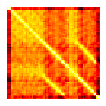

In [219]:
draw_osd_sim(data_sims[0])

In [232]:
data_sims_tril = data_sims[:, tril[0], tril[1]]
data_sims_tril.shape

(155, 2080)

In [233]:
sims_mean = []
sims_std = []
for sim in data_sims_tril:
    sims_mean.append(sim.mean())
    sims_std.append(sim.std())

(145, 64, 512)

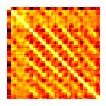

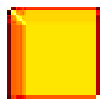

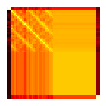

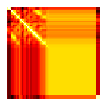

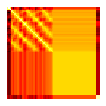

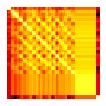

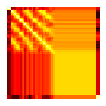

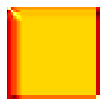

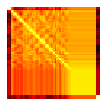

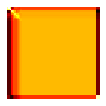

In [234]:
outlier_indices = outlier_detection(sims_mean)[0]
for idx in outlier_indices:
    draw_osd_sim(data_sims[idx])
data_feat = np.delete(data_feat, outlier_indices, axis=0)
data_feat.shape

In [235]:
data = data_feat.reshape((-1, 512))
data.shape

(9280, 512)

In [237]:
df_data = pd.DataFrame(data)

In [238]:
df_data.iloc[:, 200:210].describe()

,200,201,202,203,204,205,206,207,208,209
count,9280.000000,9280.0,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.0,9280.000000,9280.000000
mean,1.116403,0.0,0.296750,0.708412,1.150162,1.177368,0.955024,0.0,1.005732,0.682468
std,0.336091,0.0,0.258218,0.237654,0.275435,0.310399,0.364231,0.0,0.271964,0.275293
min,0.000000,0.0,0.000000,0.000000,0.257093,0.137004,0.000000,0.0,0.094479,0.000000
25%,0.882787,0.0,0.061744,0.548854,0.957179,0.959206,0.702082,0.0,0.810495,0.486551
50%,1.095698,0.0,0.258260,0.693594,1.140365,1.172889,0.955577,0.0,0.991689,0.663734
75%,1.327752,0.0,0.465886,0.856908,1.324303,1.384707,1.206488,0.0,1.187520,0.859488
max,2.467175,0.0,1.391692,1.786246,2.372484,2.383919,2.227484,0.0,2.020975,2.044044


In [239]:
data_scaler = scaler.fit_transform(data)

In [240]:
data_out = kspca.fit_transform(data_scaler)
data_out.shape

(9280, 24)

In [241]:
kspca.explained_variance_ratio_

array([0.08952484, 0.07074036, 0.05636761, 0.04403881, 0.03925429,
       0.03544855, 0.03200632, 0.02672423, 0.02404562, 0.02266385,
       0.01901987, 0.01816638, 0.01587501, 0.0136712 , 0.01308843,
       0.0121691 , 0.01093935, 0.01043945, 0.00991797, 0.00892264,
       0.0077772 , 0.00755029, 0.00692178, 0.00625961], dtype=float32)

In [242]:
np.cumsum(kspca.explained_variance_ratio_)

array([0.08952484, 0.16026519, 0.21663281, 0.26067162, 0.29992592,
       0.33537447, 0.3673808 , 0.39410502, 0.41815063, 0.4408145 ,
       0.45983437, 0.47800076, 0.49387577, 0.50754696, 0.52063537,
       0.5328045 , 0.54374385, 0.5541833 , 0.5641013 , 0.5730239 ,
       0.5808011 , 0.5883514 , 0.5952732 , 0.6015328 ], dtype=float32)

------------------------------------------------------------
KstestResult(statistic=0.10398706896551724, pvalue=0.4670868588620587)
KstestResult(statistic=0.12176724137931035, pvalue=0.2796682866929684)
KstestResult(statistic=0.1875, pvalue=0.019845194616662898)
KstestResult(statistic=0.10872844827586207, pvalue=0.4112631951275084)
KstestResult(statistic=0.10420258620689656, pvalue=0.4644667304439378)
KstestResult(statistic=0.1398706896551724, pvalue=0.1512769912458427)
KstestResult(statistic=0.1396551724137931, pvalue=0.15246652133469218)
KstestResult(statistic=0.09558189655172414, pvalue=0.5743252937348957)
KstestResult(statistic=0.09148706896551724, pvalue=0.6290762019430236)
KstestResult(statistic=0.13448275862068965, pvalue=0.18331853596641978)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
KstestResult(statistic=0.22780172413793104, pvalue=0.0022215430422748428)
KstestResult(statistic=0.26045258620689654, pvalue=0.00027262275680439707)
KstestResult(statistic=0.18243

KstestResult(statistic=0.240625, pvalue=0.001009294427520735)
KstestResult(statistic=0.06056034482758621, pvalue=0.9630169339869352)
KstestResult(statistic=0.09795258620689655, pvalue=0.5432093127729127)
KstestResult(statistic=0.2113146551724138, pvalue=0.005736446189690048)
KstestResult(statistic=0.06982758620689655, pvalue=0.8948266421905621)
KstestResult(statistic=0.18189655172413793, pvalue=0.025997565880409024)
KstestResult(statistic=0.12155172413793103, pvalue=0.2815695673554627)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
KstestResult(statistic=0.12737068965517243, pvalue=0.233436422797204)
KstestResult(statistic=0.06810344827586207, pvalue=0.9104541140932836)
KstestResult(statistic=0.19148706896551723, pvalue=0.016292989484804066)
KstestResult(statistic=0.20161637931034482, pvalue=0.009685216198820679)
KstestResult(statistic=0.11939655172413793, pvalue=0.30109062031736955)
KstestResult(statistic=0.1247844827586207, pvalue=0.2540132780284887)
KstestResult(statis

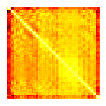

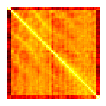

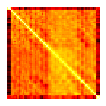

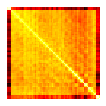

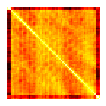

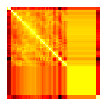

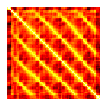

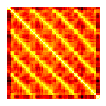

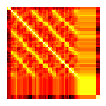

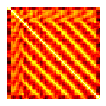

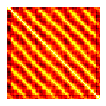

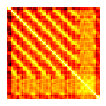

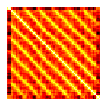

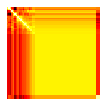

In [253]:
neg_outs = []
for s, f in zip(sims_np_055, feat_np_055):
    neg_outs.append(kspca.transform(scaler.fit_transform(f)))
    draw_osd_sim(s)
    
pos1_outs = []
for s, f in zip(sims_np_922, feat_np_922):
    pos1_outs.append(kspca.transform(scaler.fit_transform(f)))
    draw_osd_sim(s)
    
pos2_outs = []
for s, f in zip(sims_np_855, feat_np_855):
    pos2_outs.append(kspca.transform(scaler.fit_transform(f)))
    draw_osd_sim(s)

for out in (neg_outs, pos1_outs, pos2_outs):
    print('-'*60)
    for rvs in out:
        for i in range(10):
            print(stats.ks_2samp(rvs[:, i], data_out[:, i]))
        print('+'*60)
    print('\n\n')

In [ ]:
KstestResult(statistic=0.21403104026845637, pvalue=0.0049256408350399905)
KstestResult(statistic=0.10539010067114093, pvalue=0.4500411748553502)
KstestResult(statistic=0.1944211409395973, pvalue=0.014040451885774297)
KstestResult(statistic=0.24234479865771813, pvalue=0.0009035197108551163)

#### A1

In [ ]:
pca4 = PCA(n_components=4)
feat_np_905_out = pca4.fit_transform(feat_np_905_512)
np.cumsum(pca4.explained_variance_ratio_)[-1]

In [ ]:
np_info(feat_np_905_out[:, 0])

In [ ]:
feat_np_819_out = pca4.fit_transform(feat_np_819_512)
np.cumsum(pca4.explained_variance_ratio_)[-1]

In [ ]:
np_info(feat_np_819_out[:, 0])

In [ ]:
feat_np_928_out = pca4.fit_transform(feat_np_928_512)
np.cumsum(pca4.explained_variance_ratio_)[-1]

In [ ]:
np_info(feat_np_928_out[:, 0])

In [ ]:
feat_np_055_out = pca4.transform(feat_np_055_512)
np.cumsum(pca4.explained_variance_ratio_)[-1]

In [ ]:
np_info(feat_np_055_out[:, 0])

#### B

In [ ]:
a = pos_feat_np.reshape((-1, 512))

In [ ]:
feats = []
for feat in a:
    feats.append(_denormal_image(feat))

In [ ]:
feats_np = np.vstack(feats)

In [ ]:
feats_np.shape

In [ ]:
pca = PCA(n_components=64)
pca.fit(feats_np)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)[-1]

In [ ]:
plot_scatter(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
pos_feat_64 = pca.transform(feats_np)

pos_feat_64_0 = pos_feat_64 - pos_feat_64.mean(axis=0)
pos_feat_64_1 = pos_feat_64_0 - pos_feat_64_0.mean(axis=1).reshape((-1, 1))

plot_scatter(pos_feat_64_1)

In [ ]:
plt.figure(figsize=(24, 24))
plt.imshow(b[10:64])

### Neg Datasets

In [ ]:
neg_embs_files = (
    '20211201095837',
    '20211204124008',
    '20211204144055',
)

In [ ]:
neg_feat_list = []
for s in neg_embs_files:
    neg_feat_list.append(np.load(f'{EMBS_DIR}/{s}_feat.npy'))
    
neg_feat_np = np.vstack(neg_feat_list)
neg_feat_np.shape

In [ ]:
neg_sims_list = []
for s in neg_embs_files:
    neg_sims_list.append(np.load(f'{EMBS_DIR}/{s}_sims.npy')[1:-1])
    
neg_sims_np = np.vstack(neg_sims_list)
neg_sims_np.shape

## PCA

### Feat

In [ ]:
pos_feat_512 = pos_feat_np.reshape((-1, 512)).copy()
neg_feat_512 = neg_feat_np.reshape((-1, 512)).copy()
pos_feat_512.shape, neg_feat_512.shape

In [ ]:
pos_feat_512_0 = pos_feat_512 - pos_feat_512.mean(axis=0)
pos_feat_512_1 = pos_feat_512_0 - pos_feat_512_0.mean(axis=1).reshape((-1, 1))

plot_scatter(pos_feat_512_1)

In [ ]:
neg_feat_512_0 = neg_feat_512 - neg_feat_512.mean(axis=0)
neg_feat_512_1 = neg_feat_512_0 - neg_feat_512_0.mean(axis=1).reshape((-1, 1))

plot_scatter(neg_feat_512_1)
# neg_feat_512_1[100:120]

In [ ]:
neg_feat_512_0 = neg_feat_512 - pos_feat_512.mean(axis=0)
neg_feat_512_1 = neg_feat_512_0 - neg_feat_512_0.mean(axis=1).reshape((-1, 1))

plot_scatter(neg_feat_512_1)
# neg_feat_512_1[100:120]

In [ ]:
targets = [0] * pos_feat_512.shape[0] + [1] * neg_feat_512.shape[0]
# plot_scatter(pos_output, colors=targets)
plot_scatter(np.vstack([pos_feat_512_1, neg_feat_512_1]), colors=targets)

In [ ]:
pca = PCA(n_components=32)
pca.fit(pos_feat_512)

In [ ]:
pos_feat_512[1, :10]

In [ ]:
np.cumsum(pca.explained_variance_ratio_)[-1]

In [ ]:
# pos_feat_32 = pca.transform(np.concatenate([pos_feat_512, neg_feat_512], axis=0))
pos_feat_32 = pca.transform(pos_feat_512)
neg_feat_32 = pca.transform(neg_feat_512)

In [ ]:
len(pos_feat_512)

In [ ]:
neg_feat_32.shape

In [ ]:
np.percentile(pos_feat_32[:, 0], [25, 75])

In [ ]:
indexes = []
means = []
stds = []
for i in range(32):
    indexes.append(outlier_detection(pos_feat_32[:, i])[0])
    means.append(pos_feat_32[:, i].mean())
    stds.append(pos_feat_32[:, i].std())

In [ ]:
# means, stds

In [ ]:
for f in neg_feat_32:
    flg = 0
    for i in range(32):
        f[i] - means
        print()

In [ ]:
outlier_index = np.unique(np.concatenate(indexes))

In [ ]:
len(outlier_index)

In [ ]:
outlier_index[-300:]

In [ ]:
outlier_detection(pos_feat_32[:, 0])

In [ ]:
pos_feat_64 = pca.transform(pos_feat_512_1)
neg_feat_64 = pca.transform(neg_feat_512_1)

In [ ]:
targets = [0] * pos_feat_64.shape[0] + [1] * neg_feat_64.shape[0]
plot_scatter(np.vstack([pos_feat_64, neg_feat_64]), colors=targets)

In [ ]:
pos_output_1 = pca.fit_transform(pos_feat_512)
pos_output_2 = pca.fit_transform(neg_feat_512)

In [ ]:
targets = [0] * pos_feat_512.shape[0] + [1] * neg_feat_512.shape[0]
# plot_scatter(pos_output, colors=targets)
plot_scatter(np.vstack([pos_output_1, pos_output_2]), colors=targets)

### Sims

In [ ]:
tril = np.tril_indices(64)

In [ ]:
pos_sims_tril = pos_sims_np[:, tril[0], tril[1]]
neg_sims_tril = neg_sims_np[:, tril[0], tril[1]]

In [ ]:
pos_sims_tril.shape, neg_sims_tril.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline_sims = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])
# pca_sims = PCA(n_components=2)
# pca_sims.fit(pos_sims_tril)
pipeline_sims.fit(pos_sims_tril)

In [ ]:
pca = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=10))])

In [ ]:
pca.fit(pos_sims_tril)

In [ ]:
pca['pca'].explained_variance_ratio_

In [ ]:
# !pip3 install pyod  --trusted-host  mirrors.aliyun.com -i https://mirrors.aliyun.com/pypi/simple

In [ ]:
from pyod.models.pca import PCA

In [ ]:
clf = PCA(n_components=2)
clf.fit(pos_sims_tril)

In [ ]:
print(clf.labels_)

In [ ]:
clf.predict(neg_sims_tril)

In [ ]:
pos_sims_output = pipeline_sims.transform(pos_sims_tril)
neg_sims_output = pipeline_sims.transform(neg_sims_tril)
pos_sims_output.shape, neg_sims_output.shape

In [ ]:
pos_sims_output.std(), neg_sims_output.std(), pos_sims_output.mean(), neg_sims_output.mean()

In [ ]:
neg_sims_output

In [ ]:
pos_sims_output = pca_sims.transform(pos_sims_tril)
neg_sims_output = pca_sims.transform(neg_sims_tril)
pos_sims_output.shape, neg_sims_output.shape

In [ ]:
targets = [0] * pos_sims_tril.shape[0] + [1] * neg_sims_tril.shape[0]
plot_scatter(np.vstack([pos_sims_output, neg_sims_output]), colors=targets)

## A

In [ ]:
sims = ('20211130112549', '20211201074745', '20211201110905', '20211201161714')
pos_sims_list = []
for s in sims:
    pos_sims_list.append(np.load(f'/data/sims/{s}.npy'))
    
neg_sims = np.load(f'/data/sims/20211130112549.npy')

In [ ]:
pca0 = PCA()

In [ ]:
pca = PCA(n_components=2)

In [ ]:
data = np.vstack(pos_sims_list) # np.concatenate(sims_list)

In [ ]:
il1 = np.tril_indices(64)

In [ ]:
neg_features = neg_sims[:, il1[0], il1[1]]
neg_features.shape

In [ ]:
neg_features.var(axis=1)

In [ ]:
features = data[:, il1[0], il1[1]]

In [ ]:
features.shape

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

In [ ]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
features.shape

In [ ]:
pca0 = PCA().fit(features)
plt.plot(np.cumsum(pca0.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca_pos_out = pca.fit_transform(features)
pca_pos_out.var(), pca_pos_out.mean()

In [ ]:
pca_pos_out.std(axis=1)

In [ ]:
pca_neg_out = pca.fit_transform(neg_features)
pca_neg_out.var(), pca_neg_out.mean()

In [ ]:
pca_neg_out.std(axis=1)

In [ ]:
pca.explained_variance_

In [ ]:
pca.mean_, pca.explained_variance_ratio_

In [ ]:
plot_scatter(pca_pos_out)

In [ ]:
plot_scatter(pca_neg_out)

### TSNE

In [ ]:
tsne = TSNE(random_state=0)

In [ ]:
Xt = pca.fit_transform(features)
plt.scatter(Xt[:,0], Xt[:,1])

In [ ]:
Nt = pca.transform(neg_features)
plt.scatter(Nt[:,0], Nt[:,1])

In [ ]:
pca.explained_variance_ratio_

In [ ]:
tsne_results = tsne.fit_transform(features)

In [ ]:
plot_scatter(tsne_results)

### B

In [ ]:
qg_embs1 = np.load('/data/repnet_embs_qg_1.npy')
qg_embs1.shape

In [ ]:
qg_features_1 = qg_embs1[1:10].reshape(-1, 512)
qg_features_1.shape

In [ ]:
qg_tsne_1 = tsne.fit_transform(qg_features_1)

In [ ]:
plot_scatter(qg_tsne_1)

## D

```py
    def remover_outlier(self, x_pca, y_pca, x, y, label):
        # outlier_index = np.where((x_pca[:, 0:5] < -200) | (x_pca[:, 0:5] > 35))[0]
        outlier_x =[]
        for i in range(x_pca.shape[1]):
            outlier_x.append(self.outlier_detection(x_pca[:, i])[0])
        outlier_index = np.unique(np.concatenate(outlier_x))

        x_pca = np.delete(x_pca, outlier_index, axis=0)
        y_pca = np.delete(y_pca, outlier_index, axis=0)
        x = np.delete(x, outlier_index, axis=0)
        y = np.delete(y, outlier_index, axis=0)
        label = label.drop(index=outlier_index).reset_index(drop=True)
        return x_pca, y_pca, x, y, label

    def outlier_detection(self, data):
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (iqr * 1.5)
        upper_bound = q3 + (iqr * 1.5)
        return np.where((data < lower_bound) | (data > upper_bound))
```